# Importowanie bibliotek

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import ppscore as pps
import networkx as nx
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy.stats import kruskal
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import time




pd.set_option('mode.chained_assignment', None)


# Wczytanie Danych

In [5]:
data = pd.read_csv('/home/krzysztof/Kaczmarek/Projket2/ICPSR_27521/DS0001/27521-0001-Data.tsv',sep='\t')

In [6]:
columns_to_check = [
    "DEPRESSIONINDEX", "DEP_EPISODE", "MDELastYr", "ANYTXRXMDE", 
    "CATAG2", "CATAG3", "CATAG7", "IRSEX", "NEWRACE2", "ANYINDEX", "YO_MDEA6",
    "MJANDCOKE", "ILLICITDRUGUSE", "LSYRILLICIT", "COKECRACK", "OTHERILLICIT", 
    "MARJLTYR", "MJCOKELY", "COCCRKLY", "MJGT12MO", "COCGT12MO", "ANYGT12MO", 
    "ALCFMFPB", "IREDUC2", "EDU_DUMMY", "INCOME", "INCOME_R", "POVERTY", 
    "IRPRVHLT", "WORKFORCE", "EMPSTAT4", "REVERSEPOP", "MOVESPY2", "CACHAR", 
    "CATYPE", "CRIMEHIST", "ANYSDRUG", "ANYATTACK", "ANYTHEFT", "NUMARREST", 
    "HEALTH2", "SCHDSICK", "SCHDSKIP", "TXLCAD", "DSTNCALM", "DSTTIRE", 
    "DSTSITST", "DSTDEPRS", "DSTCHEER", "DSTNRVOS", "YOWRSATP", "YOWRSPLN", 
    "ADWRDLOT", "ADWRSTHK", "YO_MDEA4", "ADWRSLEP", "ADWRSMOR", "YO_MDEA3", 
    "ADWRELES", "IRMARIT", "NOMARR2", "RKIDSHH", "MARRIED", "CHILDRENINHOME"
]

available_columns = [col for col in columns_to_check if col in data.columns]

df_filtered = data[available_columns]

# Rozkład danych w zmiennej DEPRESSIONINDEX

In [7]:

def plot_percentage_barplot(data,column_name):
    depression = data[column_name]
    if depression.isnull().sum() == 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        value_counts = depression.value_counts(dropna=False)
        labels = value_counts.index.to_series().fillna('Missing Data').astype(str)
        colors = plt.cm.Paired.colors[:len(value_counts)]
        
        axes[0].bar(labels, value_counts.values, color=colors) 
        axes[0].set_title(f'{column_name} - Bar Chart')
        axes[0].set_ylabel('Count')
        axes[0].set_xlabel(column_name)
        
        def autopct_format(pct):
            return f'{pct:.1f}%' if pct >= 2 else ''  # Wyświetlaj tylko procenty >= 1%

        axes[1].pie(
            value_counts.values, 
            labels=labels, 
            autopct=autopct_format, 
            startangle=90, 
            colors=colors
        )
        axes[1].set_title(f'{column_name} - Pie Chart')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Występują brakujące wartości w kolumnie {column_name} w ilości: {depression.isnull().sum()}")

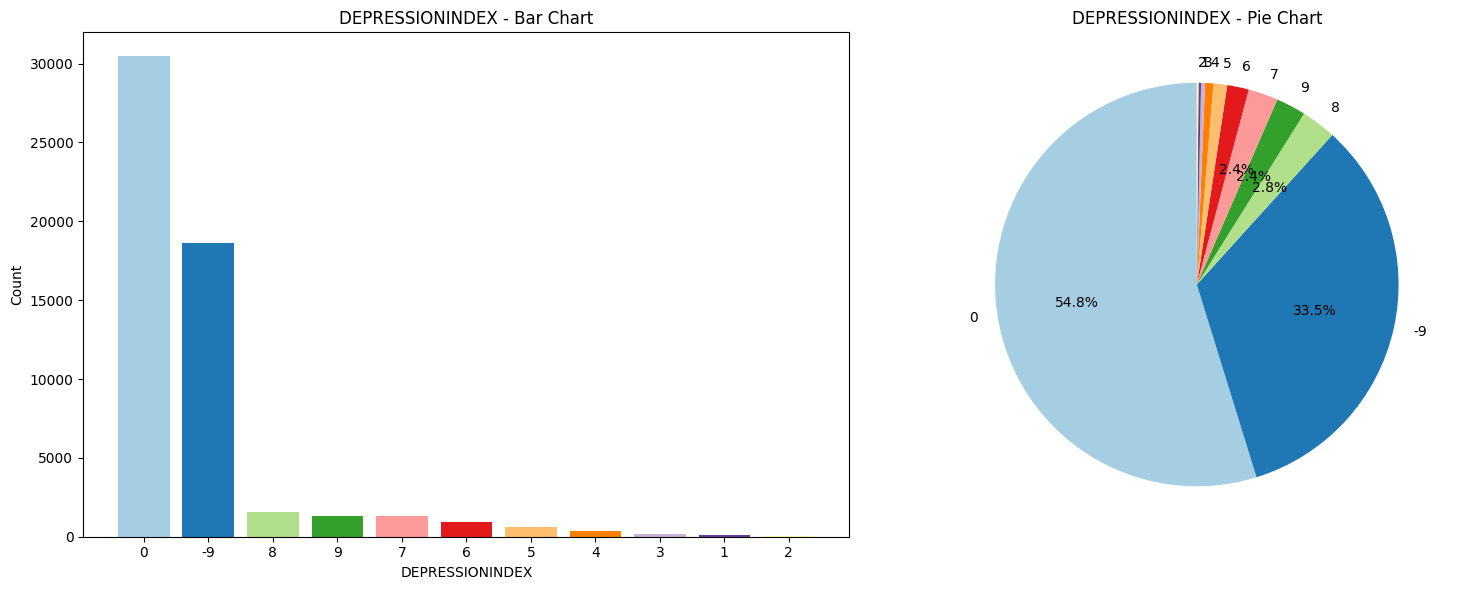

In [8]:
plot_percentage_barplot(df_filtered, 'DEPRESSIONINDEX')

# Podział na depresje somatyczną i niesomatyczną

In [9]:
#YO_MDEA4 - 1-tak, 2-nie - Sen
#YO_MDEA3 - 1-tak, 2-nie - Apetyt
#YO_MDEA6 - 1-tak, 2-nie - Zmęczenie

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       (df_filtered['YO_MDEA4'] == 1) & 
       (df_filtered['YO_MDEA3'] == 1) & 
       (df_filtered['YO_MDEA6'] == 1), 'Somatic'] = 2

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'] == 0), 'Somatic'] = 0

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       ((df_filtered['YO_MDEA4'] == 2) |
       (df_filtered['YO_MDEA3'] == 2) | 
       (df_filtered['YO_MDEA6'] == 2)), 'Somatic'] = 1

df_filtered['Somatic'].replace(np.nan, -1, inplace=True)

# Somatic - 2 - depresja somatyczn, 1 - brak depresji somatycznej, 0 - brak depresji

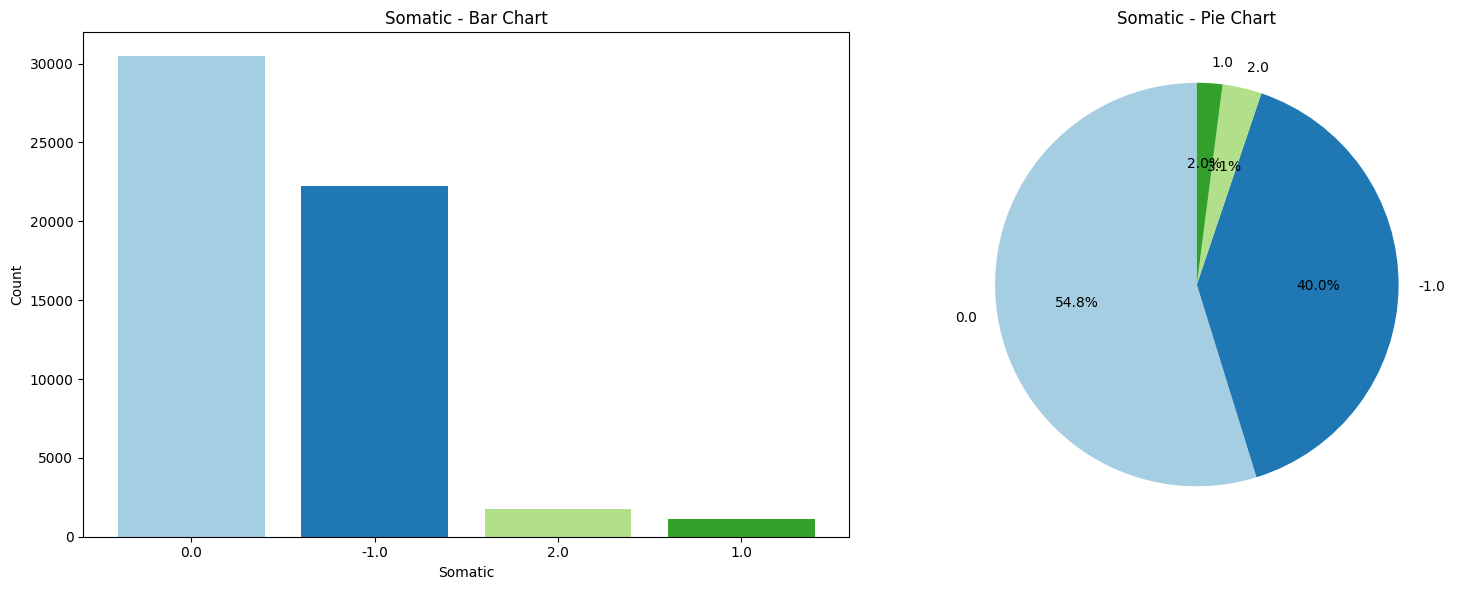

In [10]:
plot_percentage_barplot(df_filtered, 'Somatic')

# Operacje na brakach w danych

## Usunięcie kolumn gdzie występuje ponad 60% danych brakujących

In [11]:
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].replace(-9, np.nan)
df_filtered = df_filtered.dropna(subset=['DEPRESSIONINDEX'])


In [12]:
pd.set_option('display.max_rows', None)

check_nan_data = df_filtered.copy()

check_nan_data[check_nan_data == -1] = np.nan
check_nan_data[check_nan_data == -9] = np.nan

check_nan_data['YO_MDEA4'].replace([99, 98, 94, 97], np.nan, inplace=True)
check_nan_data['MOVESPY2'].replace([998, 997, 994], np.nan, inplace=True)
check_nan_data['SCHDSKIP'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['SCHDSICK'].replace([89, 90, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ALCFMFPB'].replace([94, 97, 98], np.nan, inplace=True)
check_nan_data['ADWRSTHK'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['NOMARR2'].replace([94, 97, 99], np.nan, inplace=True)
check_nan_data['ADWRELES'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA3'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSMOR'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSLEP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRDLOT'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSPLN'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSATP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNRVOS'].replace([85, 89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTCHEER'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTDEPRS'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTSITST'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTTIRE'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNCALM'].replace([94, 97, 98, 99], np.nan, inplace=True)

missing_percentage = check_nan_data.isna().mean() * 100


In [13]:
columns_to_drop = missing_percentage[missing_percentage > 60].index
check_nan_data.drop(columns=columns_to_drop, inplace=True)

In [14]:
check_nan_data.head()

,DEPRESSIONINDEX,ANYTXRXMDE,CATAG2,CATAG3,CATAG7,IRSEX,NEWRACE2,ANYINDEX,YO_MDEA6,MJANDCOKE,...,HEALTH2,SCHDSICK,SCHDSKIP,DSTCHEER,DSTNRVOS,IRMARIT,RKIDSHH,MARRIED,CHILDRENINHOME,Somatic
0,0.0,0.0,2,2,5,1,7,0.142857,99,1,...,1.0,NaN,NaN,5.0,4.0,4,0.0,0,0,0.0
1,0.0,0.0,2,2,4,1,1,0.142857,99,1,...,2.0,NaN,NaN,4.0,4.0,4,0.0,0,0,0.0
2,0.0,0.0,3,5,7,1,1,0.142857,99,0,...,1.0,NaN,NaN,5.0,5.0,1,0.0,1,0,0.0
3,0.0,0.0,2,2,5,1,1,0.500000,99,1,...,2.0,NaN,NaN,5.0,4.0,4,0.0,0,0,0.0
4,0.0,0.0,3,4,7,2,1,0.142857,99,1,...,2.0,NaN,NaN,4.0,3.0,1,1.0,1,1,0.0


In [15]:
df_filtered = check_nan_data
df_filtered_without_DEPRESSIONINDEX = check_nan_data.drop(columns=['DEPRESSIONINDEX'])

In [16]:
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].astype(int)

## Uzupełnienie brakujących danych

In [17]:
df_filtered.drop(columns=['SCHDSICK', 'SCHDSKIP', 'DSTCHEER', 'DSTNRVOS'], inplace=True)
column_with_missing_values = df_filtered.columns[df_filtered.isna().any()].tolist()
nan_counts = df_filtered[column_with_missing_values].isna().sum()
nan_counts


ANYTXRXMDE     333
ANYINDEX        29
COKECRACK      937
MJGT12MO      1620
COCGT12MO      523
ANYGT12MO     2032
ALCFMFPB       378
WORKFORCE       10
MOVESPY2        34
CACHAR           7
CATYPE          81
CRIMEHIST       99
ANYSDRUG       115
ANYATTACK       80
ANYTHEFT        90
NUMARREST      627
HEALTH2         10
RKIDSHH         24
Somatic       3632
dtype: int64

In [24]:
columns_without_missing_values = df_filtered.columns[~df_filtered.isna().any()]
df_without_missing_values = df_filtered[columns_without_missing_values]

X = df_without_missing_values.drop(columns=['DEPRESSIONINDEX']) 
y = df_without_missing_values['DEPRESSIONINDEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

method = 0
low_mse = 1000

def impute_missing_values(df, column):
    low_mse = 1000
    for method in range(3):
        print(f'Column: {column} - Method: {method}')
        if method == 0:
            imputer = SimpleImputer(strategy='median')
        if method == 1:
            imputer = SimpleImputer(strategy='mean')
        if method == 2:
            imputer = KNNImputer(n_neighbors=4)

        df_imputed = pd.DataFrame(imputer.fit_transform(df_without_missing_values), columns=df_without_missing_values.columns)

        X = df_imputed.drop(columns=['DEPRESSIONINDEX']) 
        y = df_imputed['DEPRESSIONINDEX']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < low_mse:
            low_mse = mse
            best_method = imputer

        method += 1

    return low_mse, best_method

df_without_missing_values = pd.concat([df_without_missing_values, df_filtered['CACHAR']], axis=1)

mse, imputer = impute_missing_values(df_without_missing_values, 'CACHAR')
print(f'Mean Squared Error: {mse}, Method: {imputer}')
df_without_missing_values.isna().sum()



# for column in column_with_missing_values:
#     df_without_missing_values = pd.concat([df_without_missing_values, df_filtered[column]], axis=1)
#     for method in range(3):
#         print(f'Column: {column} - Method: {method}')
#         if method == 0:
#             imputer = SimpleImputer(strategy='median')
#         if method == 1:
#             imputer = SimpleImputer(strategy='mean')
#         if method == 2:
#             imputer = KNNImputer(n_neighbors=4)

#         df_imputed = pd.DataFrame(imputer.fit_transform(df_without_missing_values), columns=df_without_missing_values.columns)

#         X = df_imputed.drop(columns=['DEPRESSIONINDEX']) 
#         y = df_imputed['DEPRESSIONINDEX']
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
#         model = LinearRegression()
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         mse = mean_squared_error(y_test, y_pred)

#         if mse < low_mse:
#             low_mse = mse
#             best_method = imputer

#         method += 1

#     print(f'Column: {column} - Mean Squared Error: {low_mse}, Method: {best_method}')
#     df_without_missing_values = pd.DataFrame(best_method.fit_transform(df_without_missing_values), columns=df_without_missing_values.columns)
#     low_mse = 1000
#     print(f"Liczba kolumn: {df_without_missing_values.shape[1]}")


# count_nan = df_without_missing_values.isna().sum()
# count_nan

    


Mean Squared Error: 3.9672751249992477
Column: CACHAR - Method: 0
Column: CACHAR - Method: 1
Column: CACHAR - Method: 2
Mean Squared Error: 3.9673471483925575, Method: SimpleImputer()


DEPRESSIONINDEX    0
CATAG2             0
CATAG3             0
CATAG7             0
IRSEX              0
NEWRACE2           0
YO_MDEA6           0
MJANDCOKE          0
ILLICITDRUGUSE     0
LSYRILLICIT        0
OTHERILLICIT       0
MARJLTYR           0
MJCOKELY           0
COCCRKLY           0
IREDUC2            0
EDU_DUMMY          0
INCOME             0
INCOME_R           0
POVERTY            0
IRPRVHLT           0
EMPSTAT4           0
REVERSEPOP         0
IRMARIT            0
MARRIED            0
CHILDRENINHOME     0
CACHAR             7
dtype: int64

In [341]:
column_with_missing_values

['ANYTXRXMDE',
 'ANYINDEX',
 'COKECRACK',
 'MJGT12MO',
 'COCGT12MO',
 'ANYGT12MO',
 'ALCFMFPB',
 'WORKFORCE',
 'MOVESPY2',
 'CACHAR',
 'CATYPE',
 'CRIMEHIST',
 'ANYSDRUG',
 'ANYATTACK',
 'ANYTHEFT',
 'NUMARREST',
 'HEALTH2',
 'RKIDSHH',
 'Somatic']

### Uzupełnienie danych za pomocą KNNImputer

In [319]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# MODEL OCENY JAKOŚCI
X = df_imputed.drop(columns=['DEPRESSIONINDEX'])  # Cechy
y = df_imputed['DEPRESSIONINDEX']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 2.8343282850114875
R-squared: 0.6138024386192178


### Uzupełnienie danych za pomocą SimpleImputer ze strategią Mean

In [326]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# MODEL OCENY JAKOŚCI
X = df_imputed.drop(columns=['DEPRESSIONINDEX'])  # Cechy
y = df_imputed['DEPRESSIONINDEX']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.574671357832445
R-squared: 0.6491825576415868


### Uzupełnienie danych za pomocą SimpleImputer ze strategią Median

In [327]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# MODEL OCENY JAKOŚCI
X = df_imputed.drop(columns=['DEPRESSIONINDEX'])  # Cechy
y = df_imputed['DEPRESSIONINDEX']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.841232571120498
R-squared: 0.6128616801077653


# Predictive Power Score dla zmiennej DEPRESSIONINDEX

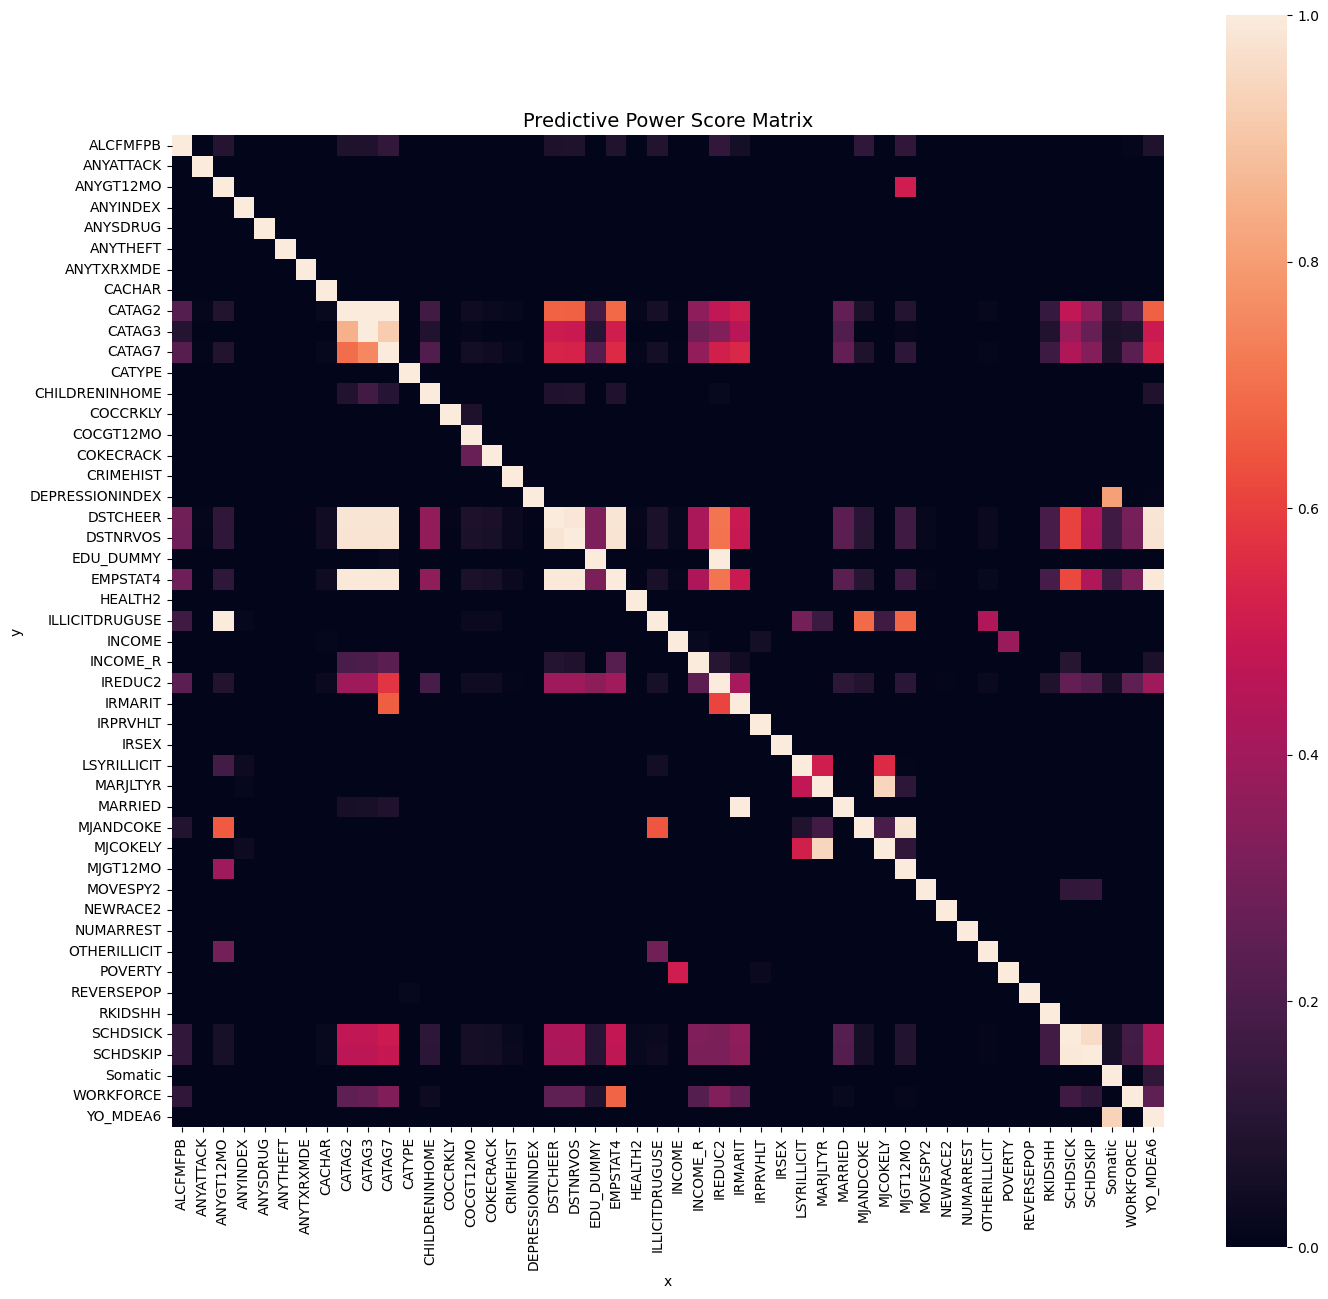

In [ ]:
pps_matrix = pps.matrix(df_filtered)
pps_matrix = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(16, 16))
sns.heatmap(pps_matrix, vmin=0, vmax=1,square=True)
plt.title('Predictive Power Score Matrix', fontsize=14)
plt.show()

In [222]:
depression_pps_colums = pps_matrix[pps_matrix.columns == 'DEPRESSIONINDEX']
depression_pps_colums = depression_pps_colums.loc[:, depression_pps_colums.ne(0).any(axis=0)]
depression_pps_colums


x,DEPRESSIONINDEX,Somatic,YO_MDEA6
y,,,
DEPRESSIONINDEX,1.0,0.807746,0.009212


Nawet że PPS nie wykazał związku DEPRESSIONINDEX z ANYTXRXMDE postanawiam usunąć tą kolumne ze względu na możliwe przecieki danych

In [223]:
features_to_drop = ['ANYTXRXMDE','YO_MDEA6']
df_filtered_without_DEPRESSIONINDEX = df_filtered_without_DEPRESSIONINDEX.drop(columns=features_to_drop)
df_filtered = df_filtered.drop(columns=features_to_drop)

# Korelacja Cech

## Wyznaczenie macierzy korelacji

In [224]:
correlation_matrix = df_filtered_without_DEPRESSIONINDEX.corr(method='pearson')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, fmt=".2f")
# plt.title("Pearson Correlation Matrix",fontsize=14)
# plt.show()

correlation_matrix2 = df_filtered_without_DEPRESSIONINDEX.corr(method='spearman')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix2, fmt=".2f")
# plt.title("Spearman Correlation Matrix",fontsize=14)
# plt.show()


In [225]:
corr_threshold = 0.8
corr_pairs = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix < 1)
corr_pairs = corr_pairs.unstack().reset_index()
corr_pairs = corr_pairs[corr_pairs[0]]
corr_pairs = corr_pairs[corr_pairs.level_0 < corr_pairs.level_1]
corr_pairs = corr_pairs.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs2 = (correlation_matrix2.abs() > corr_threshold) & (correlation_matrix2 < 1)
corr_pairs2 = corr_pairs2.unstack().reset_index()
corr_pairs2 = corr_pairs2[corr_pairs2[0]]
corr_pairs2 = corr_pairs2[corr_pairs2.level_0 < corr_pairs2.level_1]
corr_pairs2 = corr_pairs2.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs = pd.concat([corr_pairs, corr_pairs2])
corr_pairs = corr_pairs.drop_duplicates()


## Grupowanie zmiennych zależnych i redukcja cech

In [226]:

graph = nx.Graph()

features = pd.concat([corr_pairs['Feature 1'], corr_pairs['Feature 2']]).unique()
graph.add_nodes_from(features)

edges = corr_pairs[['Feature 1', 'Feature 2']].values
graph.add_edges_from(edges)

connected_components = list(nx.connected_components(graph))

groups_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(connected_components))],
    "Features": [", ".join(sorted(component)) for component in connected_components]
})

pd.set_option('display.max_colwidth', None)
groups_df


,Group,Features
0,Group 1,"CATAG2, CATAG3, CATAG7, DSTCHEER, DSTNRVOS, EMPSTAT4, IREDUC2, IRMARIT"
1,Group 2,"ILLICITDRUGUSE, MJANDCOKE"
2,Group 3,"LSYRILLICIT, MARJLTYR, MJCOKELY"
3,Group 4,"SCHDSICK, SCHDSKIP"
4,Group 5,"ANYGT12MO, MJGT12MO"


In [227]:
depression_corr1 = df_filtered.corr(method='pearson')['DEPRESSIONINDEX'].abs()
depression_corr2 = df_filtered.corr(method='spearman')['DEPRESSIONINDEX'].abs()

combined_corr = pd.concat([depression_corr1, depression_corr2], axis=1).max(axis=1)
combined_corr.sort_values(ascending=False, inplace=True)
combined_corr

DEPRESSIONINDEX    1.000000
OTHERILLICIT       0.183496
ILLICITDRUGUSE     0.182700
MJANDCOKE          0.149675
IRSEX              0.148019
DSTCHEER           0.141359
Somatic            0.136917
LSYRILLICIT        0.136487
ANYGT12MO          0.133392
DSTNRVOS           0.124752
ANYINDEX           0.124340
HEALTH2            0.111211
MJGT12MO           0.106763
MJCOKELY           0.102968
MARJLTYR           0.099455
ANYATTACK          0.097400
ALCFMFPB           0.081226
IRMARIT            0.079328
IREDUC2            0.072569
COCGT12MO          0.070378
COCCRKLY           0.061653
ANYTHEFT           0.059594
CRIMEHIST          0.057895
MOVESPY2           0.056314
ANYSDRUG           0.051453
CATAG7             0.050720
SCHDSICK           0.044429
WORKFORCE          0.036505
EMPSTAT4           0.035647
SCHDSKIP           0.035104
NUMARREST          0.033697
EDU_DUMMY          0.031859
INCOME             0.031781
IRPRVHLT           0.030567
RKIDSHH            0.028966
MARRIED            0

In [228]:
best_features = []
for group in connected_components:
    group_corr = combined_corr[list(group)]  
    best_feature = group_corr.idxmax()  
    best_features.append(best_feature)

best_features_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(best_features))],
    "Best Feature": best_features
})

best_features_df

,Group,Best Feature
0,Group 1,DSTCHEER
1,Group 2,ILLICITDRUGUSE
2,Group 3,LSYRILLICIT
3,Group 4,SCHDSICK
4,Group 5,ANYGT12MO


In [229]:
all_unique_features = list(set([feature for group in connected_components for feature in group]))
features_to_drop = list(set(all_unique_features) - set(best_features))
features_to_drop

['MJCOKELY',
 'IRMARIT',
 'CATAG7',
 'EMPSTAT4',
 'DSTNRVOS',
 'CATAG3',
 'IREDUC2',
 'MARJLTYR',
 'SCHDSKIP',
 'MJGT12MO',
 'MJANDCOKE',
 'CATAG2']

## Wybór kluczowych cech dla modelu

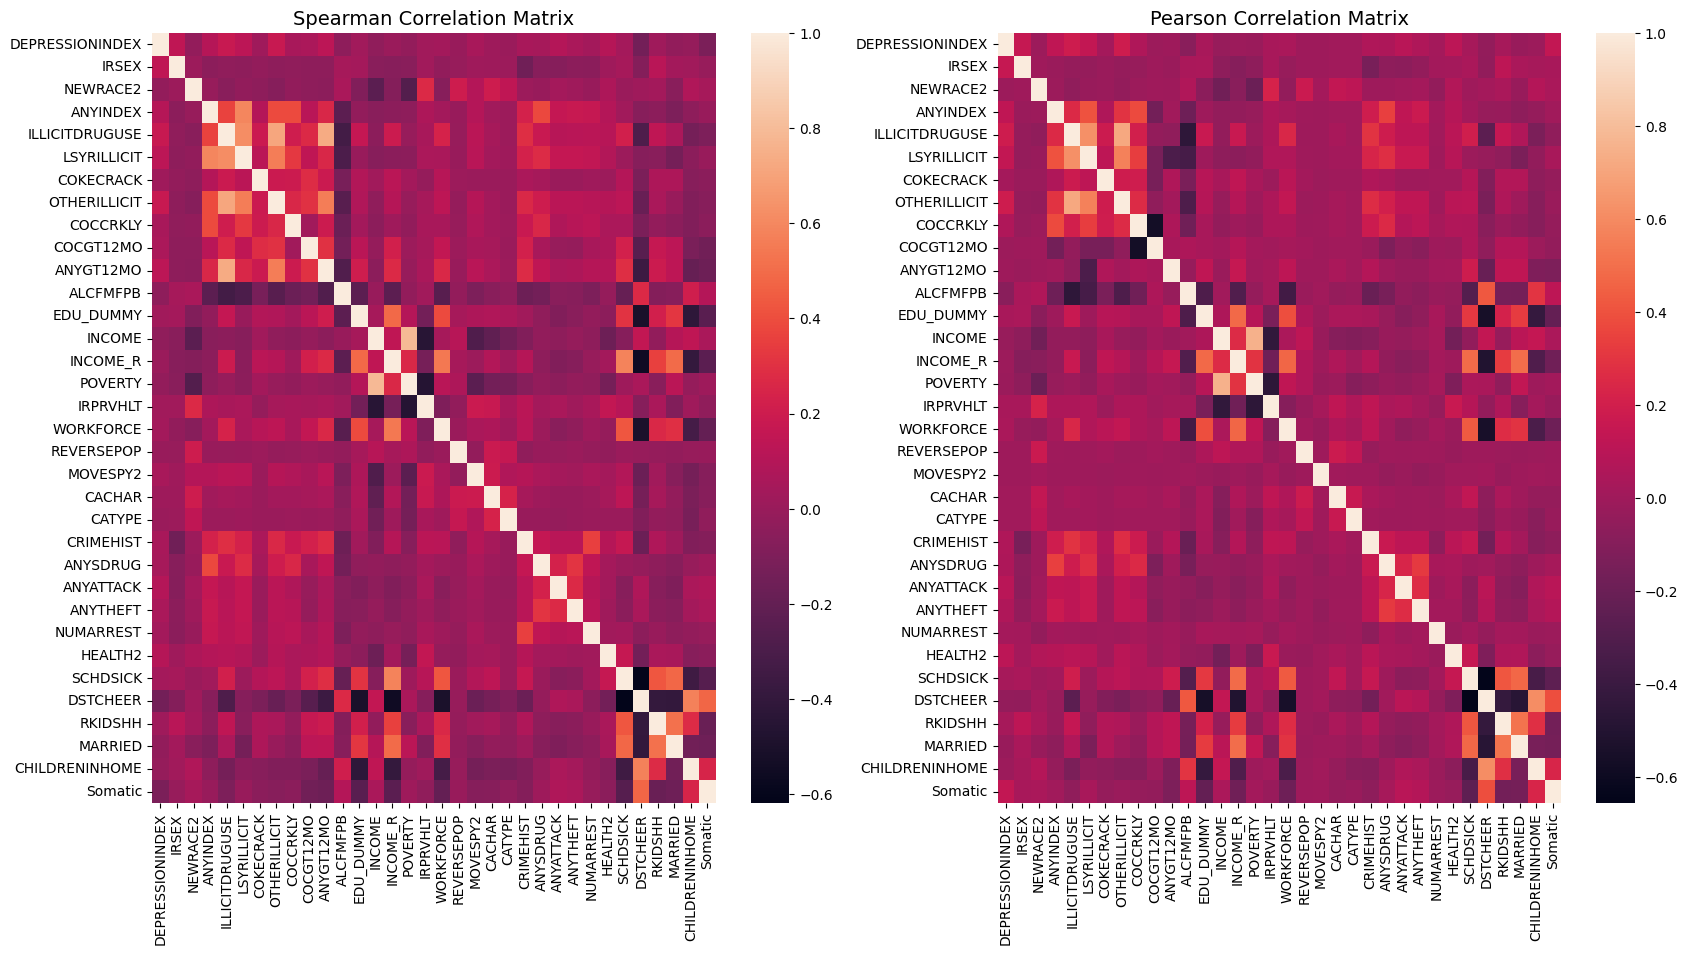

In [230]:
new_correlation_matrix = df_filtered.drop(columns=features_to_drop)

fig, ax = plt.subplots(ncols=2,figsize=(20, 10))
sns.heatmap(new_correlation_matrix.corr(method='spearman'), fmt=".2f", ax=ax[0])
ax[0].set_title("Spearman Correlation Matrix",fontsize=14)
sns.heatmap(new_correlation_matrix.corr(method='pearson'), fmt=".2f", ax=ax[1])
ax[1].set_title("Pearson Correlation Matrix",fontsize=14)
plt.show()


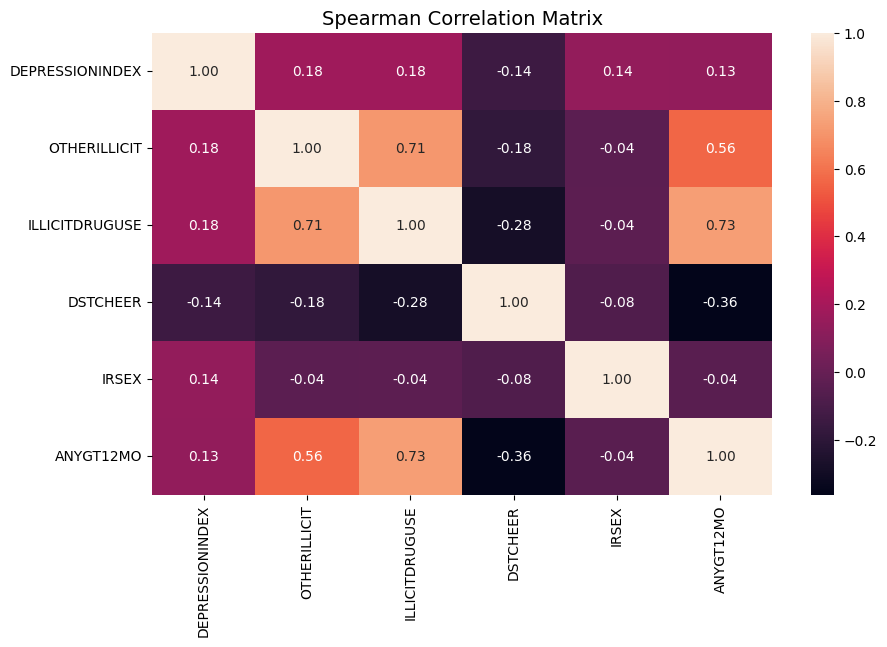

In [231]:
list_to_check = new_correlation_matrix.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check = list_to_check[:6].index.tolist()
corr_data = new_correlation_matrix[list_to_check]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

In [232]:
list_to_check.append('CATAG7')
list_to_check.append('Somatic')
df_filtered[list_to_check].head()

,DEPRESSIONINDEX,OTHERILLICIT,ILLICITDRUGUSE,DSTCHEER,IRSEX,ANYGT12MO,CATAG7,Somatic
0,0,0,1,5,1,1,5,0.0
1,0,0,1,4,1,1,4,0.0
2,0,0,0,5,1,0,7,0.0
3,0,1,1,5,1,1,5,0.0
4,0,0,1,4,2,1,7,0.0


# Wykresy DEPRESSIONINDEX w kategoriach

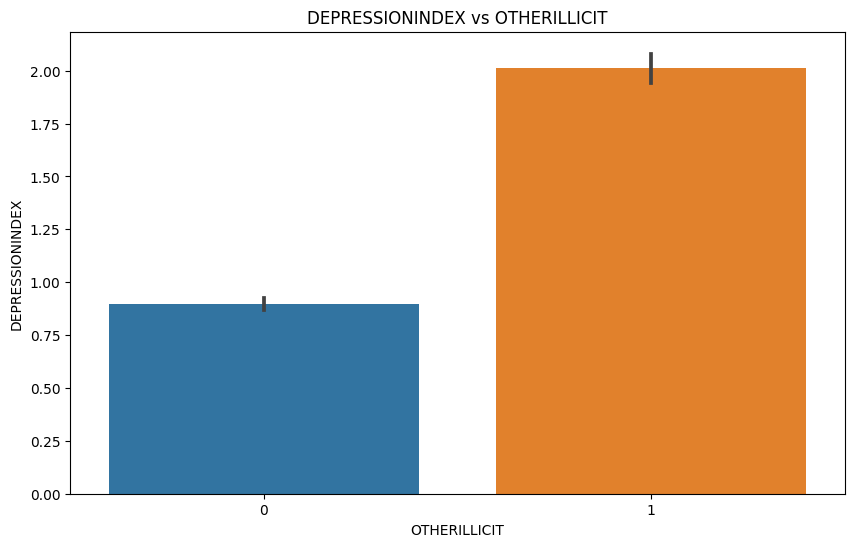

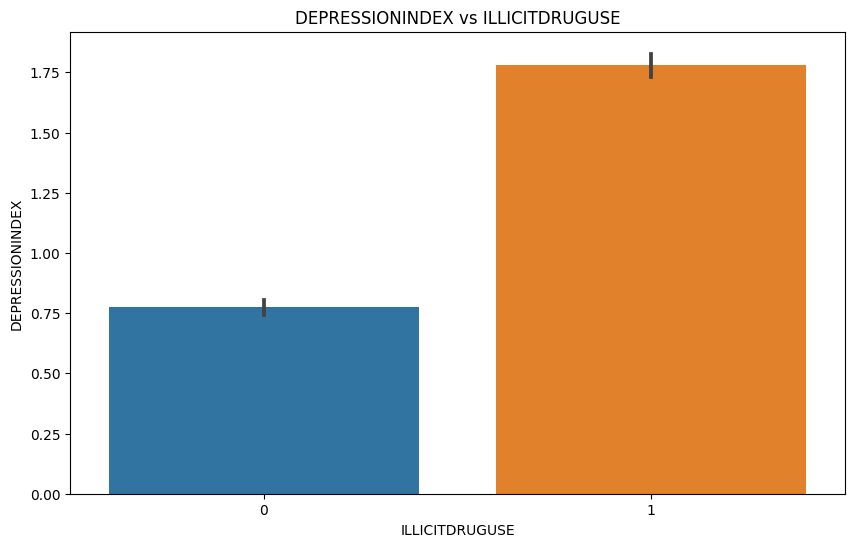

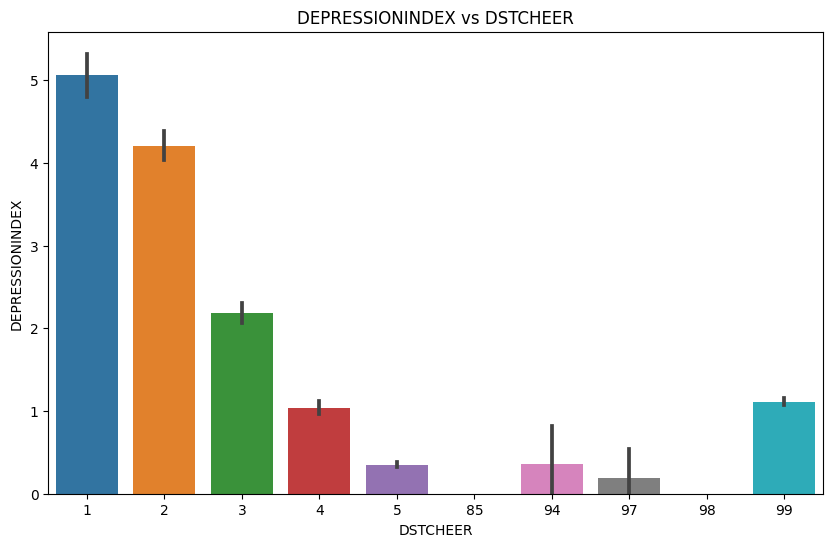

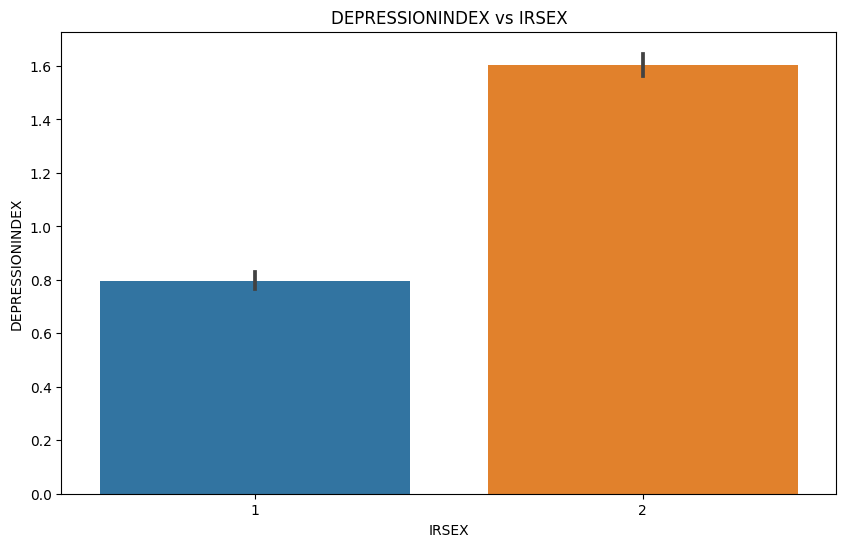

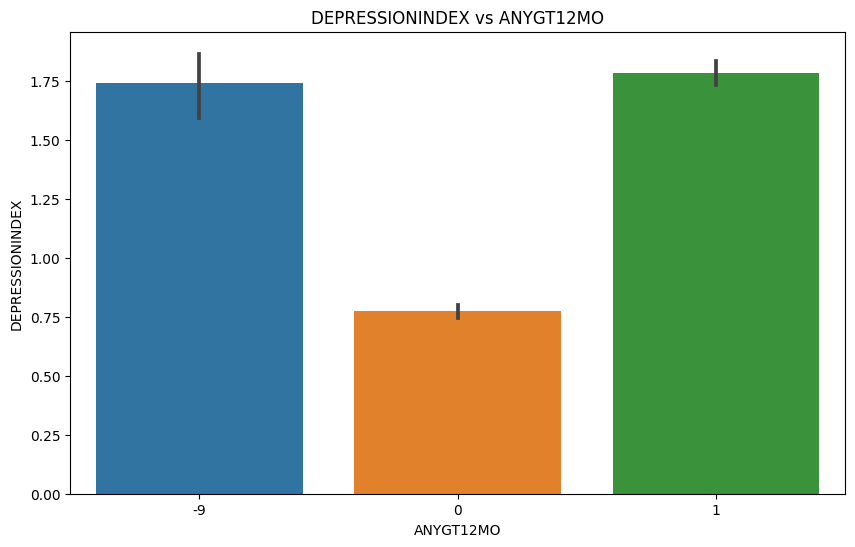

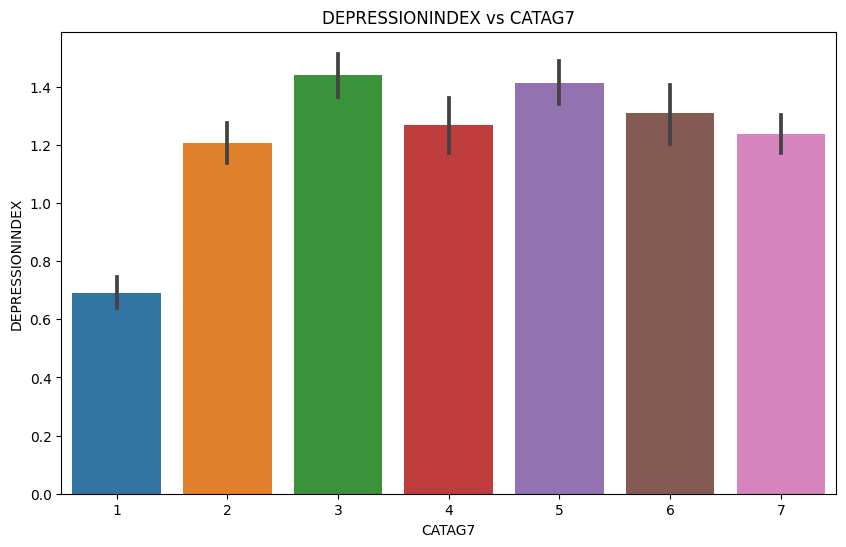

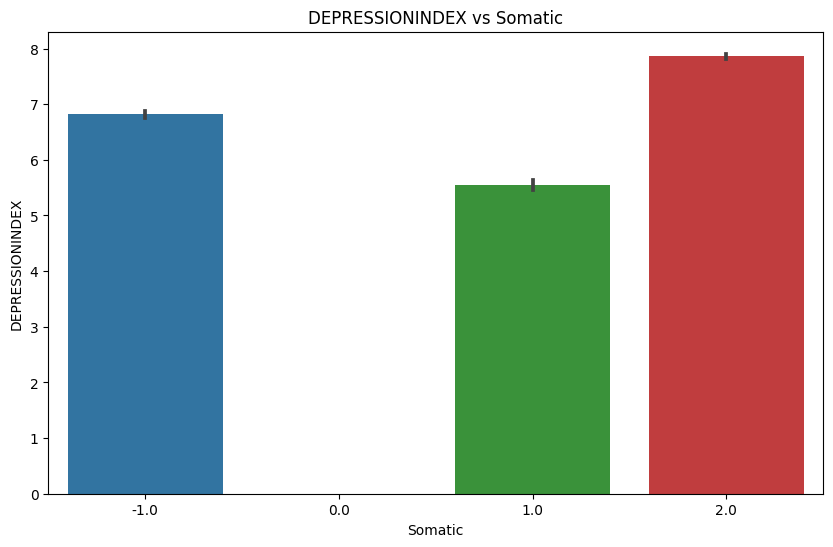

In [233]:
Boost_data = df_filtered[list_to_check]
for column in Boost_data.columns:
    if column != 'DEPRESSIONINDEX':
        plt.figure(figsize=(10,6))
        sns.barplot(data=Boost_data, x = column, y = 'DEPRESSIONINDEX')
        plt.title(f'DEPRESSIONINDEX vs {column}')
        plt.show()


# Test ANOVA

In [166]:
df_filtered.head()

,DEPRESSIONINDEX,CATAG2,CATAG3,CATAG7,IRSEX,NEWRACE2,ANYINDEX,MJANDCOKE,ILLICITDRUGUSE,LSYRILLICIT,...,HEALTH2,SCHDSICK,SCHDSKIP,DSTCHEER,DSTNRVOS,IRMARIT,RKIDSHH,MARRIED,CHILDRENINHOME,Somatic
0,0,2,2,5,1,7,0.142857,1,1,1,...,1,99,99,5,4,4,0,0,0,0.0
1,0,2,2,4,1,1,0.142857,1,1,0,...,2,99,99,4,4,4,0,0,0,0.0
2,0,3,5,7,1,1,0.142857,0,0,0,...,1,99,99,5,5,1,0,1,0,0.0
3,0,2,2,5,1,1,0.500000,1,1,1,...,2,99,99,5,4,4,0,0,0,0.0
4,0,3,4,7,2,1,0.142857,1,1,0,...,2,99,99,4,3,1,1,1,1,0.0


In [167]:
Boost_data = df_filtered[list_to_check]

In [168]:
for column in Boost_data.columns:
    if column != 'DEPRESSIONINDEX':
        groups_gender = [Boost_data['DEPRESSIONINDEX'][Boost_data[column] == group] for group in Boost_data[column].unique()]
        anova_result_gender = f_oneway(*groups_gender)
        print(f"\nANOVA dla {column}:")
        print(f"F-statystyka: {anova_result_gender.statistic:.2f}, p-wartość: {anova_result_gender.pvalue:.4f}")



ANOVA dla OTHERILLICIT:
F-statystyka: 1288.18, p-wartość: 0.0000

ANOVA dla ILLICITDRUGUSE:
F-statystyka: 1276.65, p-wartość: 0.0000

ANOVA dla DSTCHEER:
F-statystyka: 597.86, p-wartość: 0.0000

ANOVA dla IRSEX:
F-statystyka: 828.15, p-wartość: 0.0000

ANOVA dla ANYGT12MO:
F-statystyka: 638.56, p-wartość: 0.0000

ANOVA dla CATAG7:
F-statystyka: 50.29, p-wartość: 0.0000


In [ ]:
for column in Boost_data.columns:
    if column != 'DEPRESSIONINDEX':
        model = ols(f'DEPRESSIONINDEX ~ C({column})', data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)

                       sum_sq       df         F    PR(>F)
C(OTHERILLICIT)  1.263200e+02      1.0  4.481709  0.034264
Residual         1.567124e+06  55600.0       NaN       NaN
                         sum_sq       df           F        PR(>F)
C(ILLICITDRUGUSE)  3.304426e+03      1.0  117.476017  2.405022e-27
Residual           1.563946e+06  55600.0         NaN           NaN
                   sum_sq       df           F         PR(>F)
C(DSTCHEER)  3.378983e+04      9.0  136.107903  3.530733e-255
Residual     1.533460e+06  55592.0         NaN            NaN
                sum_sq       df          F        PR(>F)
C(IRSEX)  1.992654e+03      1.0  70.781691  4.083641e-17
Residual  1.565257e+06  55600.0        NaN           NaN
                    sum_sq       df           F         PR(>F)
C(ANYGT12MO)  2.018186e+04      2.0  362.650835  3.320394e-157
Residual      1.547068e+06  55599.0         NaN            NaN
                 sum_sq       df            F  PR(>F)
C(CATAG7)  3.030439e+0

In [170]:
X = Boost_data.drop(columns='DEPRESSIONINDEX')
y = Boost_data['DEPRESSIONINDEX']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(
    iterations=100,  # liczba iteracji
    depth=8,         # maksymalna głębokość drzewa
    learning_rate=0.1,  # współczynnik uczenia
    verbose=10       # logowanie co 10 iteracji
)

# Trenowanie modelu
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

0:	learn: 1.7453317	total: 48.4ms	remaining: 4.79s
10:	learn: 0.8864735	total: 133ms	remaining: 1.08s
20:	learn: 0.7580973	total: 233ms	remaining: 876ms
30:	learn: 0.7241108	total: 359ms	remaining: 800ms
40:	learn: 0.7138274	total: 461ms	remaining: 663ms
50:	learn: 0.7094425	total: 561ms	remaining: 539ms
60:	learn: 0.7072526	total: 743ms	remaining: 475ms
70:	learn: 0.7056301	total: 860ms	remaining: 351ms
80:	learn: 0.7046532	total: 957ms	remaining: 224ms
90:	learn: 0.7036786	total: 1.07s	remaining: 106ms
99:	learn: 0.7028396	total: 1.18s	remaining: 0us
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6130
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00       117
           6       0.00      0.00      0.00       182
        

/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [172]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 8.412440838404327
Mean Absolute Error: 1.147261663286004


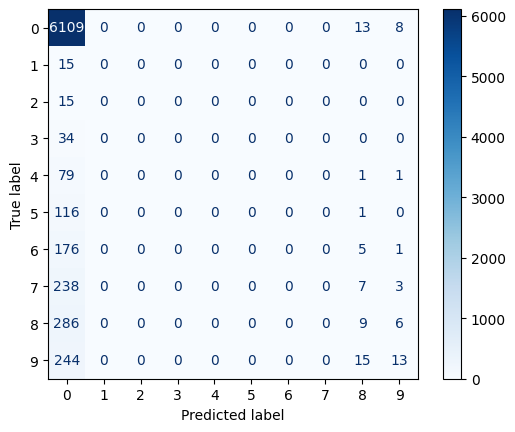

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')


In [ ]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Trenowanie modelu OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Podsumowanie modelu
print(ols_model.summary())

# Predykcja na zbiorze testowym
y_pred = ols_model.predict(X_test_sm)

# Ewaluacja modelu
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     340.4
Date:                Sat, 11 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:30:12   Log-Likelihood:                -70750.
No. Observations:               29577   AIC:                         1.415e+05
Df Residuals:                   29570   BIC:                         1.416e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8612      0.103     -8.